In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *
from lib.keras_utils import *
from lib.OptCarlini import *

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import regularizers

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

Plotting setup

In [9]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['legend.fontsize'] = 'x-large'
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.frameon'] = False

import itertools
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))

### 2-class vs N-class DNN

In [98]:
a = 3
b = 7

x_train_ab = x_train[[y == a or y == b for y in y_train]]
y_train_ab = y_train[[y == a or y == b for y in y_train]]
y_train_ab[y_train_ab == a] = 0
y_train_ab[y_train_ab == b] = 1
y_train_ab_cat = keras.utils.to_categorical(y_train_ab)

x_test_ab = x_test[[y == a or y == b for y in y_test]]
y_test_ab = y_test[[y == a or y == b for y in y_test]]
y_test_ab[y_test_ab == a] = 0
y_test_ab[y_test_ab == b] = 1
y_test_ab_cat = keras.utils.to_categorical(y_test_ab)

model = build_cnn_mnist_2cls()
model.fit(x_train_ab, y_train_ab_cat,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test_ab, y_test_ab_cat))
score = model.evaluate(x_test_ab, y_test_ab_cat, verbose=0)
print(score)

Train on 12396 samples, validate on 2038 samples
Epoch 1/10
12396/12396 [==============================] - 2s 130us/step - loss: 0.0945 - acc: 0.9674 - val_loss: 0.0473 - val_acc: 0.9823
Epoch 2/10
12396/12396 [==============================] - 1s 74us/step - loss: 0.0321 - acc: 0.9894 - val_loss: 0.0437 - val_acc: 0.9848
Epoch 3/10
12396/12396 [==============================] - 1s 74us/step - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0165 - val_acc: 0.9926
Epoch 4/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0139 - val_acc: 0.9941
Epoch 5/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0121 - val_acc: 0.9946
Epoch 6/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0083 - val_acc: 0.9980
Epoch 7/10
12396/12396 [==============================] - 1s 69us/step - loss: 0.0074 - acc: 0.9975 - val_loss: 0.0106 - val_acc

In [114]:
x_adv = PGD(model, x_test_ab[:1000], y_test_ab[:1000], grad_fn=None, norm="inf", 
            n_step=10, step_size=0.01, target=False, init_rnd=0.1)

Finished 200 samples in 4.26s.
Finished 400 samples in 3.74s.
Finished 600 samples in 3.84s.
Finished 800 samples in 3.85s.


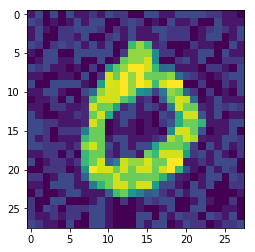

In [67]:
plt.imshow(x_adv[1].reshape(28,28))

In [115]:
model.evaluate(x_adv, y_test_ab_cat[:1000])

1000/1000 [==============================] - 0s 73us/step


[0.672608332157135, 0.807]

In [14]:
model = build_cnn_mnist()
model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')

In [94]:
acc = []
for n_step in range(5, 55, 5):
    x_adv = PGD(model, x_test, y_test, grad_fn=None, norm="inf", 
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    acc.append(model.evaluate(x_adv, y_test_ab_cat, verbose=0))

Finished 200 samples in 12.16s.
Finished 400 samples in 11.57s.
Finished 600 samples in 11.60s.
Finished 800 samples in 11.87s.


In [95]:
model.evaluate(x_adv, y_test_cat[:1000])

1000/1000 [==============================] - 0s 76us/step


[4.454765869140625, 0.1]

In [96]:
np.mean(np.linalg.norm((x_adv - x_test[:1000]).reshape(-1, 784), axis=-1, ord=np.inf))

0.30000004

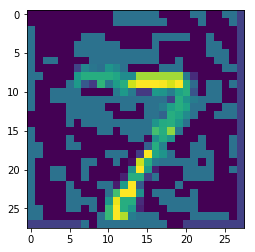

In [97]:
plt.imshow(x_adv[0].reshape(28,28))

In [161]:
path = './tmp/num_class_experiment/'
# clean_acc = pickle.load(open(path + 'clean_acc.p', 'rb'))
adv_acc = pickle.load(open(path + 'adv_acc.p', 'rb'))

In [162]:
acc = np.zeros(10)
for a in adv_acc:
    for i in range(10):
        acc[i] += a[i][1]
acc /= len(adv_acc)

In [165]:
adv_acc = pickle.load(open(path + '10cls_acc.p', 'rb'))

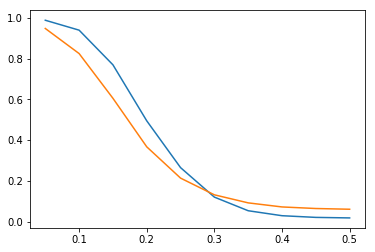

In [166]:
eps = np.arange(0.05, 0.55, 0.05)
plt.plot(eps, acc)
plt.plot(eps, [x[1] for x in adv_acc])

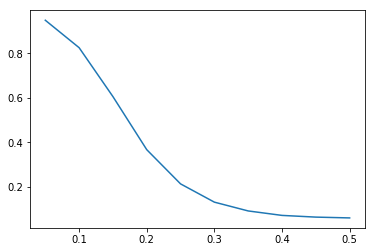

In [160]:
eps = np.arange(0.05, 0.55, 0.05)
plt.plot(eps, [x[1] for x in adv_acc])

--- 
## Gaussian Ball Experiment

Generate dataset

In [80]:
path = './data/gauss/'
n = 70000
n_train = 60000
d = 500

mean_a = np.zeros(d)
mean_b = np.ones(d)
std = np.sqrt(d) / 6.  # touching at 3 std
x_a = np.random.normal(loc=mean_a, scale=std, 
                       size=(int(n/2), d))
x_b = np.random.normal(loc=mean_b, scale=std, 
                       size=(int(n/2), d))
x = np.concatenate([x_a, x_b])
y = np.concatenate(([0] * int(n/2), [1] * int(n/2)))
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=n_train)

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
pickle.dump([x_train, y_train, x_test, y_test], 
            open('{}d{}.p'.format(path, d), 'wb'), protocol=4)

Load dataset

In [5]:
data_path = './data/gauss/'
path = './tmp/gauss/'
d = 500
x_train, y_train, x_test, y_test = pickle.load(
    open('{}d{}.p'.format(data_path, d), 'rb'))
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [95]:
model_100 = build_dnn_baseline(100)
model_500 = build_dnn_baseline(500)

In [44]:
model.fit(x_train[:5000], y_train_cat[:5000],
          batch_size=50,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test_cat))

Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 408us/step - loss: 0.1357 - acc: 0.9438 - val_loss: 0.0273 - val_acc: 0.9908
Epoch 2/10
5000/5000 [==============================] - 1s 228us/step - loss: 0.0100 - acc: 0.9982 - val_loss: 0.0198 - val_acc: 0.9932
Epoch 3/10
5000/5000 [==============================] - 1s 216us/step - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 4/10
5000/5000 [==============================] - 1s 221us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 0.0151 - val_acc: 0.9948
Epoch 5/10
5000/5000 [==============================] - 1s 213us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9949
Epoch 6/10
5000/5000 [==============================] - 1s 220us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9951
Epoch 7/10
5000/5000 [==============================] - 1s 222us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9953

In [17]:
model.save_weights('./tmp/gauss/weights_d{}_baseline.h5'.format(d))

In [83]:
model.load_weights('./tmp/gauss/weights_d{}_baseline.h5'.format(d))

In [84]:
x_adv = PGD(model, x_test[:100], y_test[:100], grad_fn=None, norm="inf", 
            n_step=50, step_size=0.01, target=False, init_rnd=0.)

In [64]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 0s 990us/step


[4.575765495300293, 0.44]

In [76]:
for i in range(20):
    print(np.where(x_adv[i] - x_test[i] > 0))

(array([47]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]),)
(array([ 0,  1,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 87, 88, 89,
       90, 91, 92, 93, 95, 96, 97, 98, 99]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27

In [87]:
np.linalg.norm(x_adv - x_test[:100], axis=1, ord=np.inf)

array([0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999

In [301]:
adv_acc1 = pickle.load(open(path + 'adv_acc_d100_baseline.p', 'rb'))
adv_acc2 = pickle.load(open(path + 'adv_acc_d500_baseline.p', 'rb'))

In [38]:
adv_acc1[1]

[0.984, 0.9464, 0.8605, 0.717, 0.5213, 0.3136, 0.1568, 0.0611, 0.0193, 0.0049]

In [33]:
adv_acc2[1]

[0.9893, 0.9541, 0.8666, 0.7254, 0.5238, 0.319, 0.161, 0.066, 0.0188, 0.0045]

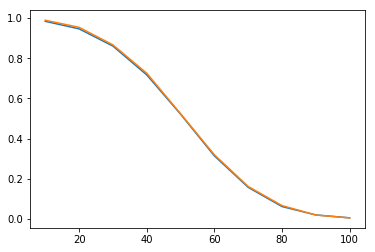

In [59]:
plt.plot(adv_acc1[0], adv_acc1[1])
plt.plot(adv_acc2[0], adv_acc2[1])

In [12]:
x1 = x_test[y_test==0, 123]
y1 = x_test[y_test==0, 12]
x2 = x_test[y_test==1, 123]
y2 = x_test[y_test==1, 12]

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = pca.fit_transform(x_test)

In [17]:
x1 = x[y_test==0, 0]
y1 = x[y_test==0, 1]
x2 = x[y_test==1, 0]
y2 = x[y_test==1, 1]

In [28]:
size = 1000
x1 = np.random.normal(0, np.sqrt(2)/6, size=size)
y1 = np.random.normal(0, np.sqrt(2)/6, size=size)
x2 = np.random.normal(1, np.sqrt(2)/6, size=size)
y2 = np.random.normal(1, np.sqrt(2)/6, size=size)

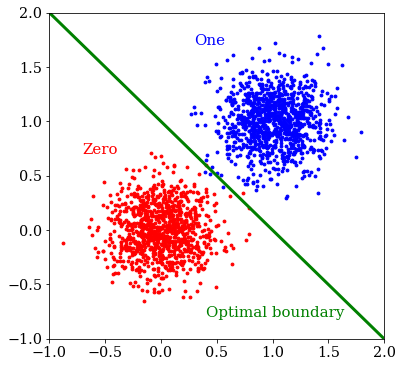

In [72]:
plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, label='Zero', c='r', s=8)
plt.scatter(x2, y2, label='One', c='b', s=8)
plt.plot(np.arange(-1, 3)[::-1], np.arange(-1, 3), c='g', linewidth=3)
#plt.xlabel('Number of steps used to generate PGD adversarial examples')
#plt.ylabel('Accuracy (%)')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
#legend = plt.legend(title='Label', fontsize='x-large', markerscale=3, loc='best')
plt.text(-0.7, 0.7, 'Zero', fontsize=15, color='r')
plt.text(0.3, 1.7, 'One', fontsize=15, color='b')
plt.text(0.4, -0.8, 'Optimal boundary', fontsize=15, color='g')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "left"
plt.savefig('./fig/gauss_diagram.pdf', bbox_inches='tight')
plt.show()

#### Model Complexity
Linear SVM

In [19]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.)
svm.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [12]:
svm.score(x_test, y_test)

0.997

In [24]:
adv_acc = []

for eps in eps_list:
    grad = svm.coef_[0]
    x_adv = np.zeros_like(x_test)

    for i, (x, y) in enumerate(zip(x_test, y_test)):
        if not y:
            x_adv[i] = x + np.sign(grad) * eps
        else:
            x_adv[i] = x - np.sign(grad) * eps

    adv_acc.append(svm.score(x_adv, y_test))

In [12]:
eps_list = np.arange(0.1, 1.1, 0.1)
adv_acc_500 = np.array([0.986, 0.9537, 0.8592, 0.7054, 0.4923, 0.288, 0.1364, 0.0503, 0.0126, 0.0021]) * 100
adv_acc_100 = np.array([0.9885, 0.9561, 0.8723, 0.718, 0.5062, 0.2895, 0.1251, 0.0412, 0.0108, 0.0022]) * 100

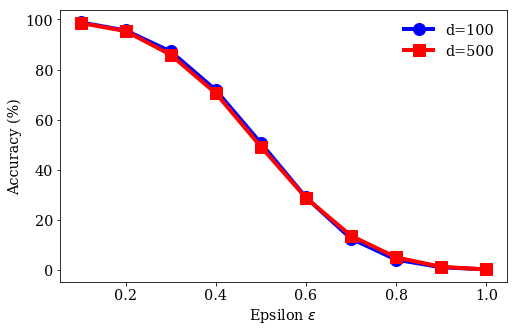

In [39]:
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))
plt.figure(figsize=(8, 5))
plt.plot(eps_list, adv_acc_100, label='d=100', color='b', marker=next(marker))
plt.plot(eps_list, adv_acc_500, label='d=500', color='r', marker=next(marker))
plt.xlabel(r'Epsilon $\epsilon$')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('./fig/svm_gauss.pdf', bbox_inches='tight')
plt.show()

In [203]:
svm.intercept_

array([-1.56052449])

In [202]:
np.sum(svm.coef_)

3.275094463213529

In [205]:
np.sum(svm.coef_ > 0)

500

In [26]:
w = svm.coef_
mean = np.mean(w100)
print(mean)
print(np.std(w100) / mean)
print(svm.intercept_)

0.11363474621264505
0.2192338805861708
[-5.6483178]


In [28]:
svm.intercept_ / mean

array([-49.63785591])

In [25]:
w = svm.coef_
mean = np.mean(w500)
print(mean)
print(np.std(w500) / mean)
print(svm.intercept_)

0.0216794411672221
0.4410750176025412
[-5.6483178]


In [19]:
svm.intercept_ / mean

array([-246.53620456])

In [9]:
np.sum(np.square(svm.coef_))

1.3530516712423102

In [13]:
np.sum(np.square(svm.coef_))

0.28071749180598493

In [17]:
from scipy.spatial.distance import cosine

print(cosine(svm.coef_, np.ones(500)))
w500 = svm.coef_

0.08504792181613463


In [21]:
print(cosine(svm.coef_, np.ones(100)))
w100 = svm.coef_

0.023198758461428937


Changing depths (no hidden (~ logistic regression), 2, 4, 8)

In [309]:
model = Sequential()
model.add(Dense(2, input_dim=d, activation='linear'))
model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [14]:
model.fit(x_train, y_train_cat,
          batch_size=50,
          epochs=100,
          verbose=1,
          callbacks=[earlystop],
          validation_data=(x_test, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 58us/step - loss: 0.3392 - acc: 0.8800 - val_loss: 0.1230 - val_acc: 0.9792
Epoch 2/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0845 - acc: 0.9905 - val_loss: 0.0616 - val_acc: 0.9937
Epoch 3/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0459 - acc: 0.9958 - val_loss: 0.0376 - val_acc: 0.9960
Epoch 4/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0289 - acc: 0.9971 - val_loss: 0.0258 - val_acc: 0.9966
Epoch 5/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0198 - acc: 0.9980 - val_loss: 0.0187 - val_acc: 0.9973
Epoch 6/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0145 - acc: 0.9983 - val_loss: 0.0146 - val_acc: 0.9975
Epoch 7/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0112 - acc: 0.9984 - val_loss: 0.0120 - 

In [15]:
model.save_weights('{}weights_d{}_depth{}.h5'.format(path, d, 0))

In [310]:
model.load_weights('{}weights_d{}_depth{}.h5'.format(path, d, 0))

In [312]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 0s 48us/step


[0.009852771656082768, 0.9967]

In [317]:
steps = np.array(range(100, 150, 10))
for n_step in steps:
    x_adv = PGD(model, x_test[:100], y_test[:100], grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_test_cat[:100])
    print(score[1])

100/100 [==============================] - 0s 127us/step
0.3
100/100 [==============================] - 0s 103us/step
0.24
100/100 [==============================] - 0s 84us/step
0.19
100/100 [==============================] - 0s 102us/step
0.12
100/100 [==============================] - 0s 78us/step
0.08


In [129]:
out_path = './tmp/gauss/'

for d in [500]:
    model = Sequential()
    model.add(Dense(2, input_dim=d, activation='linear'))
    model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
    model.load_weights('{}weights_d{}_depth{}.h5'.format(out_path, d, 0))
    print(model.evaluate(x_test, y_test_cat))
    
    for width in [40, 200, 1000, 5000]:
        model = build_dnn_wd(d, width, 2, out_dim=2)
        model.load_weights('{}weights_d{}_width{}.h5'.format(out_path, d, width))
        print(model.evaluate(x_test, y_test_cat))
        
    for depth in [1, 2, 4, 8, 16]:
        model = build_dnn_wd(d, 1000, depth, out_dim=2)
        model.load_weights('{}weights_d{}_depth{}.h5'.format(out_path, d, depth))
        print(model.evaluate(x_test, y_test_cat))

10000/10000 [==============================] - 1s 116us/step
[0.005856082954211161, 0.9982]
10000/10000 [==============================] - 1s 138us/step
[0.00643209421128704, 0.9978]
10000/10000 [==============================] - 1s 132us/step
[0.007158805751173395, 0.9978]
10000/10000 [==============================] - 1s 141us/step
[0.006954027240488114, 0.9982]
10000/10000 [==============================] - 1s 146us/step
[0.008888529565885619, 0.9964]
10000/10000 [==============================] - 1s 128us/step
[0.007297106870895732, 0.9979]
10000/10000 [==============================] - 1s 142us/step
[0.009527201462704898, 0.9973]
10000/10000 [==============================] - 2s 156us/step
[0.01081239316393976, 0.9962]
10000/10000 [==============================] - 2s 200us/step
[0.01479761506075738, 0.9963]
10000/10000 [==============================] - 3s 283us/step
[0.023755059307813645, 0.9976]


In [5]:
out_path = './tmp/gauss/'
d = 500
#steps, adv_acc1 = pickle.load(open(out_path + 'adv_acc_d100_depth-width.p', 'rb'))
steps, adv_acc2 = pickle.load(open(out_path + 'adv_acc_d100_depth-width.p', 'rb'))
steps, adv_acc3 = pickle.load(open(out_path + 'adv_acc_d100_depth-width_2.p', 'rb'))

In [6]:
adv_acc2[0] = adv_acc3[0]
adv_acc_d = adv_acc2[:5]
adv_acc_d.append(adv_acc3[1])
adv_acc_w = [adv_acc2[0]]
adv_acc_w.extend(adv_acc2[5:])

adv_acc_d = np.array(adv_acc_d) * 100
adv_acc_w = np.array(adv_acc_w) * 100

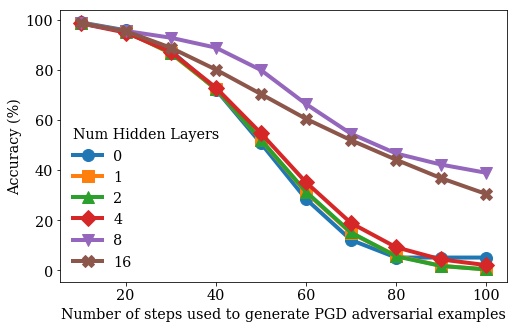

In [10]:
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))
labels = ['0', '1', '2', '4', '8', '16']
plt.figure(figsize=(8, 5))
for i, acc in enumerate(adv_acc_d):
    plt.plot(steps, acc, label=labels[i], marker=next(marker))
plt.xlabel('Number of steps used to generate PGD adversarial examples')
plt.ylabel('Accuracy (%)')
legend = plt.legend(title='Num Hidden Layers', fontsize='x-large', loc='lower left')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "left"
plt.savefig('./fig/gauss_500_depth.pdf', bbox_inches='tight')
plt.show()

Changing width (40, 200, 1000, 5000)

In [19]:
for width in [40, 200, 1000, 5000]:
    model = Sequential()
    model.add(Dense(width, input_dim=d, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(width, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='linear'))
    model.compile(loss=output_fn,
                  optimizer=keras.optimizers.Adam(lr=1e-4),
                  metrics=['accuracy'])
    model.fit(x_train, y_train_cat,
              batch_size=50,
              epochs=50,
              verbose=1,
              callbacks=[earlystop],
              validation_data=(x_test, y_test_cat))
    model.save_weights('{}weights_d{}_width{}.h5'.format(path, d, width))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 180us/step - loss: 0.1699 - acc: 0.9320 - val_loss: 0.0332 - val_acc: 0.9924
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0292 - acc: 0.9915 - val_loss: 0.0150 - val_acc: 0.9962
Epoch 3/50
60000/60000 [==============================] - 9s 150us/step - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0104 - val_acc: 0.9970
Epoch 4/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.0144 - acc: 0.9952 - val_loss: 0.0087 - val_acc: 0.9969
Epoch 5/50
60000/60000 [==============================] - 9s 148us/step - loss: 0.0120 - acc: 0.9959 - val_loss: 0.0079 - val_acc: 0.9973
Epoch 6/50
60000/60000 [==============================] - 9s 147us/step - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0074 - val_acc: 0.9974
Epoch 7/50
60000/60000 [==============================] - 9s 150us/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0072 -

In [20]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 79us/step


[0.013215170873210053, 0.9963]

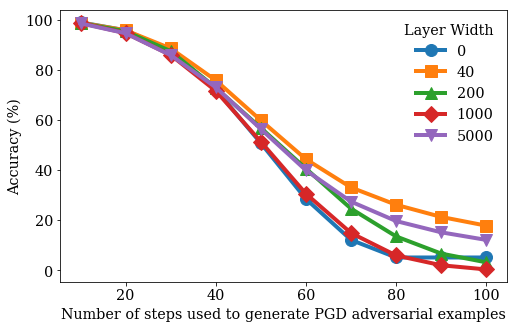

In [11]:
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))
labels = ['0', '40', '200', '1000', '5000']
plt.figure(figsize=(8, 5))
for i, acc in enumerate(adv_acc_w):
    plt.plot(steps, acc, label=labels[i], marker=next(marker))
plt.xlabel('Number of steps used to generate PGD adversarial examples')
plt.ylabel('Accuracy (%)')
legend = plt.legend(title='Layer Width', fontsize='x-large', loc='upper right')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/gauss_500_width.pdf', bbox_inches='tight')
plt.show()

Training set size (0.01, 0.1, 0.5, 2, 5)

In [78]:
path = './tmp/gauss/'

In [12]:
for r in [0.1]:
    
    model = build_dnn_wd(d, 1600, 4) 
    x_t, _, y_t, _ = train_test_split(x_train, y_train, train_size=r)
    y_t_cat = keras.utils.to_categorical(y_t)
    
    model.fit(x_t, y_t_cat,
               batch_size=50,
               epochs=50,
               verbose=1,
               callbacks=[earlystop],
               validation_data=(x_test, y_test_cat))
    #model.save_weights('{}weights_d{}_L_train{}.h5'.format(path, d, r))
    print(model.evaluate(x_test, y_test_cat))

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 6000 samples, validate on 10000 samples
Epoch 1/50
6000/6000 [==============================] - 4s 717us/step - loss: 0.0901 - acc: 0.9630 - val_loss: 0.0276 - val_acc: 0.9903
Epoch 2/50
6000/6000 [==============================] - 2s 302us/step - loss: 0.0088 - acc: 0.9967 - val_loss: 0.0208 - val_acc: 0.9930
Epoch 3/50
6000/6000 [==============================] - 2s 297us/step - loss: 0.0047 - acc: 0.9992 - val_loss: 0.0214 - val_acc: 0.9930
Epoch 4/50
6000/6000 [==============================] - 2s 288us/step - loss: 0.0062 - acc: 0.9973 - val_loss: 0.0305 - val_acc: 0.9906
Epoch 5/50
6000/6000 [==============================] - 2s 316us/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.0288 - val_acc: 0.9920
Epoch 6/50
6000/6000 [==============================] - 2s 291us/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.0299 - val_acc: 0.9926
Epoch 7/50
10000/10000 [==============================] - 1s 77us/step
[0.02893858062393292, 0.992]


In [120]:
model = build_dnn_wd(d, 2000, 5) 
model.load_weights('./tmp/gauss/weights_d500_2000-5_train0.01.h5')

In [117]:
steps = np.array(range(10, 110, 10))
for n_step in steps:
    x_adv = PGD(model, x_test, y_test, grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_test_cat)
    print(score[1])

200/200 [==============================] - 0s 2ms/step
0.89
200/200 [==============================] - 0s 92us/step
0.75
200/200 [==============================] - 0s 99us/step
0.555
200/200 [==============================] - 0s 97us/step
0.39
200/200 [==============================] - 0s 105us/step
0.225
200/200 [==============================] - 0s 99us/step
0.13
200/200 [==============================] - 0s 118us/step
0.1
200/200 [==============================] - 0s 99us/step
0.055
200/200 [==============================] - 0s 100us/step
0.025


KeyboardInterrupt: 

In [ ]:
model = build_dnn_wd(d, 2000, 5) 
model.load_weights('./tmp/gauss/weights_d500_2000-5_train0.1.h5')
steps = np.array(range(10, 110, 10))
for n_step in steps:
    x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_test_cat[:200])
    print(score[1])

In [120]:
path = './tmp/gauss/'
#d = 100 
d = 500
train = pickle.load(open('{}train-info_d{}_train.p'.format(path, d), 'rb'))
steps, adv_acc = pickle.load(open('{}adv_acc_d{}_train.p'.format(path, d), 'rb'))
adv_acc = np.array(adv_acc) * 100

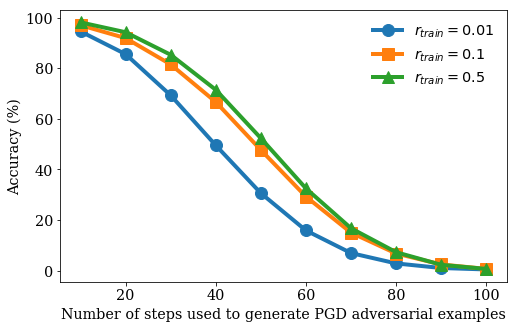

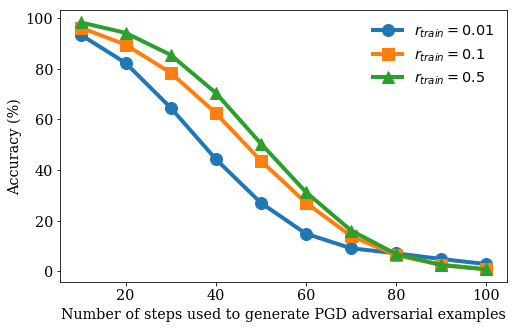

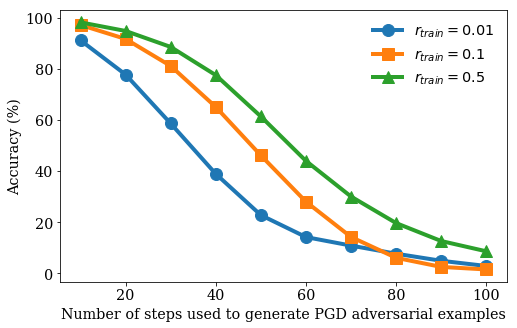

In [121]:
marker = ['o', 's', '^', 'D', 'v', 'X', 'd', '+']
labels = [r'$r_{train}=0.01$', r'$r_{train}=0.1$', r'$r_{train}=0.5$']

for i in range(3):
    plt.figure(figsize=(8, 5))
    plt.plot(steps, adv_acc[0][i], label=labels[0], marker=marker[0])
    plt.plot(steps, adv_acc[1][i], label=labels[1], marker=marker[1])
    plt.plot(steps, adv_acc[2][i], label=labels[2], marker=marker[2])
    plt.legend()
    plt.xlabel('Number of steps used to generate PGD adversarial examples')
    plt.ylabel('Accuracy (%)')
    legend = plt.legend(fontsize='x-large', loc='upper right')
    plt.setp(legend.get_title(), fontsize='x-large')
    legend._legend_box.align = "right"
    plt.savefig('./fig/gauss_500_train_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()

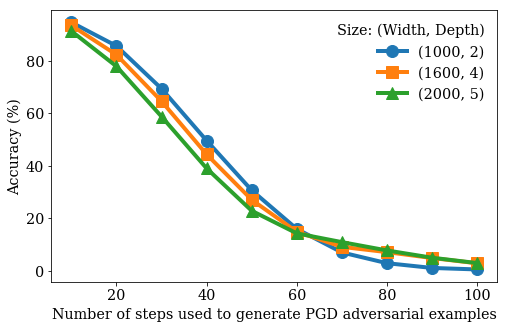

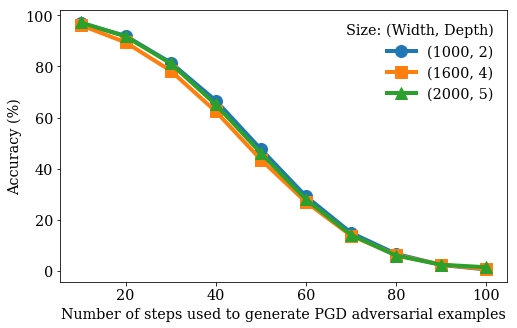

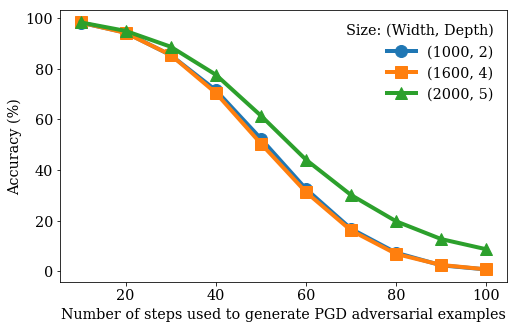

In [122]:
marker = ['o', 's', '^', 'D', 'v', 'X', 'd', '+']
labels = ['(1000, 2)', '(1600, 4)', '(2000, 5)']

for i in range(3):
    plt.figure(figsize=(8, 5))
    plt.plot(steps, adv_acc[i][0], label=labels[0], marker=marker[0])
    plt.plot(steps, adv_acc[i][1], label=labels[1], marker=marker[1])
    plt.plot(steps, adv_acc[i][2], label=labels[2], marker=marker[2])
    plt.legend()
    plt.xlabel('Number of steps used to generate PGD adversarial examples')
    plt.ylabel('Accuracy (%)')
    legend = plt.legend(title='Size: (Width, Depth)', fontsize='x-large', loc='upper right')
    plt.setp(legend.get_title(), fontsize='x-large')
    legend._legend_box.align = "right"
    plt.savefig('./fig/gauss_500_size_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()

In [133]:
train100 = pickle.load(open('./tmp/gauss/train-info_d100_train.p', 'rb'))
train500 = pickle.load(open('./tmp/gauss/train-info_d500_train.p', 'rb'))

In [134]:
train100

[[[4.662867373554036e-05, 1.0, 0.015581710898556048, 0.9938],
  [7.927266112043678e-06, 1.0, 0.022133727413235466, 0.9929],
  [1.6966089922334505e-05, 1.0, 0.02964934873702914, 0.991]],
 [[4.5804963756381765e-05, 1.0, 0.010179972274770807, 0.9958],
  [0.0001540543025799804, 1.0, 0.023497599331346215, 0.9942],
  [0.0001036922332746606, 1.0, 0.01753131359720237, 0.9942]],
 [[0.00013321084526489056, 1.0, 0.01282117299372867, 0.9963],
  [0.0004636985709279448, 0.9999, 0.01220504256905767, 0.9966],
  [0.0016665682506907616, 0.9999666666666667, 0.012579810577001263, 0.9959]]]

In [135]:
train500

[[[0.00014040442649275065, 1.0, 0.03881420908346772, 0.9867],
  [3.157036577855858e-06, 1.0, 0.043850115190818904, 0.9829],
  [4.855841956062553e-06, 1.0, 0.06367428877530619, 0.9779]],
 [[0.00034262781877373644, 1.0, 0.03819325614446091, 0.9919],
  [0.0024741302417151056, 0.9988333333333334, 0.04946269133056534, 0.99],
  [7.601274789125274e-05, 1.0, 0.02491917304961189, 0.993]],
 [[0.00034652448140455713, 0.9999, 0.012304986752893262, 0.9962],
  [0.0003636400196318843, 0.9999666666666667, 0.012071017920579616, 0.9964],
  [0.0008902975676974696, 0.9998333333333334, 0.015450470417831094, 0.9952]]]

Combine plot

In [12]:
svm = [0.986, 0.9537, 0.8592, 0.7054, 0.4923, 0.288, 0.1364, 0.0503, 0.0126, 0.0021]
svm = np.array(svm) * 100

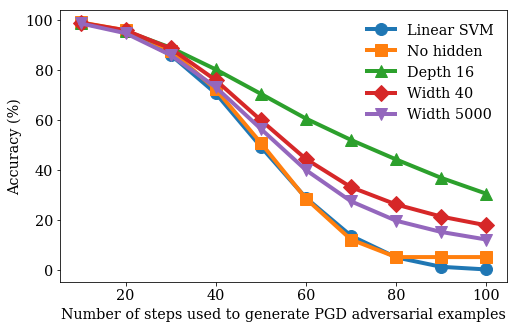

In [14]:
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))
labels = ['0', '40', '200', '1000', '5000']
plt.figure(figsize=(8, 5))
plt.plot(steps, svm, label='Linear SVM', marker=next(marker))
plt.plot(steps, adv_acc_d[0], label='No hidden', marker=next(marker))
plt.plot(steps, adv_acc_d[-1], label='Depth 16', marker=next(marker))
plt.plot(steps, adv_acc_w[1], label='Width 40', marker=next(marker))
plt.plot(steps, adv_acc_w[-1], label='Width 5000', marker=next(marker))

plt.xlabel('Number of steps used to generate PGD adversarial examples')
plt.ylabel('Accuracy (%)')
legend = plt.legend(fontsize='x-large', loc='upper right')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/gauss_combine.pdf', bbox_inches='tight')
plt.show()

## Uniform spheres

In [16]:
path = './data/sphere/'
n = 2000 # 70000
n_train = 1000 # 60000
d = 2

r = 1
R = 1.3
x = np.random.normal(loc=0, scale=1, size=(n, d))
x /= np.linalg.norm(x, axis=1, keepdims=True)
x[:n//2] *= r
x[n//2:] *= R
y = np.concatenate(([0] * (n//2), [1] * (n//2)))
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=n_train)

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
x1 = x_train[y_train==0, 0]
y1 = x_train[y_train==0, 1]
x2 = x_train[y_train==1, 0]
y2 = x_train[y_train==1, 1]

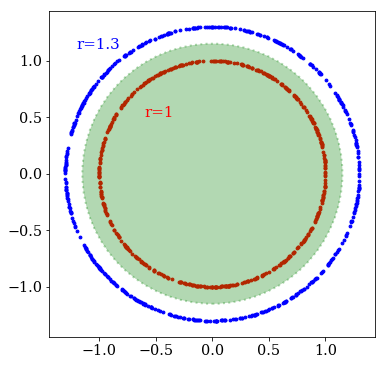

In [33]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal')
ax.add_patch(
    patches.Circle(
        (0, 0),
        1.15,
        linewidth=2,
        linestyle='dotted',
        color='g',
        alpha=0.3
    )
)
plt.scatter(x1, y1, label='Zero', c='r', s=8)
plt.scatter(x2, y2, label='One', c='b', s=8)
#plt.plot(np.arange(-1, 3)[::-1], np.arange(-1, 3), c='g', linewidth=3)
#plt.xlabel('Number of steps used to generate PGD adversarial examples')
#plt.ylabel('Accuracy (%)')
# plt.xlim([-1, 2])
# plt.ylim([-1, 2])
#legend = plt.legend(title='Label', fontsize='x-large', markerscale=3, loc='best')
plt.text(-1.2, 1.1, 'r=1.3', fontsize=15, color='b')
plt.text(-0.6, 0.5, 'r=1', fontsize=15, color='r')
#plt.text(0.4, -0.8, 'Optimal boundary', fontsize=15, color='g')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "left"
plt.savefig('./fig/sphere_diagram.pdf', bbox_inches='tight')
plt.show()

In [136]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [32]:
pickle.dump([x_train, y_train, x_test, y_test], 
            open('{}sphere_d{}.p'.format(path, d), 'wb'), protocol=4)

In [12]:
r = 0.1
p = np.random.permutation(len(x_train))
x_train, y_train = x_train[p], y_train[p]
n_t = int(len(x_train) * r)
x_t = np.concatenate(
    (x_train[y_train == 0][:n_t // 2], x_train[y_train == 1][:n_t // 2]))
y_t = np.concatenate(
    (y_train[y_train == 0][:n_t // 2], y_train[y_train == 1][:n_t // 2]))
y_t_cat = keras.utils.to_categorical(y_t)

In [5]:
data_path = './data/sphere/'
path = './tmp/sphere/'
d = 500
x_train, y_train, x_test, y_test = pickle.load(
    open('{}sphere_d{}.p'.format(data_path, d), 'rb'))
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [8]:
model = build_dnn_baseline(500)
model.load_weights('./tmp/sphere/weights_d500_1000-2.h5')
print(model.evaluate(x_train, y_train_cat))
print(model.evaluate(x_test, y_test_cat))

60000/60000 [==============================] - 4s 66us/step
[0.0003428103106659061, 1.0]
10000/10000 [==============================] - 1s 60us/step
[0.0006118757113465108, 1.0]


In [21]:
model = Sequential()
model.add(Lambda(lambda x: x ** 2, input_shape=(d,)))
model.add(Dense(2, activation='linear'))
model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.load_weights('./tmp/sphere/weights_d500_quad.h5')
print(model.evaluate(x_train, y_train_cat))
print(model.evaluate(x_test, y_test_cat))

60000/60000 [==============================] - 3s 50us/step
[1.253188914997736e-05, 1.0]
10000/10000 [==============================] - 1s 60us/step
[1.2595931548275984e-05, 1.0]


In [8]:
reg = 1e-9
model = Sequential()
model.add(Dense(1000, activation='linear', input_shape=(d,), 
                kernel_regularizer=regularizers.l2(reg)))
model.add(Lambda(lambda x: x ** 2))
model.add(Dense(2, activation='linear',
                kernel_regularizer=regularizers.l2(reg)))
model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [13]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(
    './tmp.h5', save_best_only=True, save_weights_only=True, period=1)
model.fit(x_train, y_train_cat,
          batch_size=128,
          epochs=100,
          verbose=1,
          callbacks=[earlystop, checkpoint],
          validation_data=(x_test, y_test_cat))
model.load_weights('./tmp.h5')
print(model.evaluate(x_train, y_train_cat))
print(model.evaluate(x_test, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.6831 - acc: 0.4996 - val_loss: 0.6719 - val_acc: 0.5049
Epoch 2/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.6605 - acc: 0.4992 - val_loss: 0.6502 - val_acc: 0.5049
Epoch 3/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.6378 - acc: 0.4992 - val_loss: 0.6329 - val_acc: 0.5049
Epoch 4/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.6179 - acc: 0.4992 - val_loss: 0.6180 - val_acc: 0.5049
Epoch 5/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.5951 - acc: 0.4992 - val_loss: 0.5966 - val_acc: 0.5049
Epoch 6/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.5607 - acc: 0.5939 - val_loss: 0.5634 - val_acc: 0.6610
Epoch 7/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5107 - acc: 0.9223 - val_loss: 0.5186 - 

Epoch 59/100
60000/60000 [==============================] - 2s 32us/step - loss: 1.3193e-05 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9957
Epoch 60/100
60000/60000 [==============================] - 2s 33us/step - loss: 1.2838e-05 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9957
Epoch 61/100
60000/60000 [==============================] - 2s 36us/step - loss: 1.2553e-05 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9957
Epoch 62/100
60000/60000 [==============================] - 3s 47us/step
[1.3838375330184742e-05, 1.0]
10000/10000 [==============================] - 1s 52us/step
[0.01213082912559621, 0.996]


In [14]:
model.save_weights('{}weights_d{}_1000-quad_reg{}.h5'.format(path, d, reg))

In [37]:
path = './tmp/sphere/'
adv_acc = pickle.load(open(path + 'adv_acc_1m.p', 'rb'))
x_adv = pickle.load(open(path + 'adv_1m.p', 'rb'))

In [38]:
adv_acc

[[0.0, 0.9522, 0.7943, 0.5056, 0.0, 1.0, 1.0, 1.0]]

In [42]:
model.load_weights('{}weights_d{}_1000-quad.h5'.format(path, d))
x_a = x_adv[0]
adv = []
for x in x_a[:4]:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

model.load_weights('{}weights_d{}_1000-quad_1m.h5'.format(path, d))

adv = []
for x in x_a[4:]:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

[0.10051599773189314, 0.024155044231568685, 0.0543725598973336, 0.08131985788867031]


/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.15726999654191998, nan, nan, nan]


In [43]:
path = './tmp/sphere/'
adv_acc = pickle.load(open(path + 'adv_acc_base.p', 'rb'))
x_adv = pickle.load(open(path + 'adv_base.p', 'rb'))

In [44]:
adv_acc

[[0.0247, 0.9984, 0.9709, 0.8244, 0.0, 1.0, 1.0, 1.0]]

In [46]:
model = build_dnn_baseline(500)
model.load_weights('{}weights_d{}_1000-2.h5'.format(path, d))
x_a = x_adv[0]
adv = []
for x in x_a[:4]:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

model = Sequential()
model.add(Lambda(lambda x: x ** 2, input_shape=(d,)))
model.add(Dense(2, activation='linear'))
model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.load_weights('{}weights_d{}_quad.h5'.format(path, d))

adv = []
for x in x_a[4:]:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

[0.11224859254794652, 0.027379944209170032, 0.06178956868861893, 0.09225841005789846]


/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.1609501886720096, nan, nan, nan]


In [6]:
path = './tmp/sphere/'
adv_acc = pickle.load(open(path + 'adv_acc_reg_2.p', 'rb'))
x_adv = pickle.load(open(path + 'adv_reg_2.p', 'rb'))

In [7]:
adv_acc

[[0.0001, 0.9632, 0.8427, 0.598],
 [0.0006, 0.9565, 0.8193, 0.5469],
 [0.0016, 0.9583, 0.8044, 0.5299]]

In [10]:
model.load_weights('{}weights_d{}_1000-quad_reg1e-07.h5'.format(path, d))
x_a = x_adv[0]
adv = []
for x in x_a:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

model.load_weights('{}weights_d{}_1000-quad_reg1e-08.h5'.format(path, d))
x_a = x_adv[1]
adv = []
for x in x_a:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

model.load_weights('{}weights_d{}_1000-quad_reg1e-09.h5'.format(path, d))
x_a = x_adv[2]
adv = []
for x in x_a:
    ind = np.argmax(model.predict(x), axis=1) != y_test
    norm = np.linalg.norm(x - x_test, axis=1)
    adv.append(np.mean(norm[ind]))
print(adv)

[0.10446793566936693, 0.024819476712800513, 0.05473673918341023, 0.08170395000648732]
[0.10194007633107932, 0.02445199752954808, 0.054238652732250425, 0.08159996150756892]
[0.10105338487276933, 0.024142011798443132, 0.05563373043503923, 0.08157333340171444]


In [59]:
np.sum(ind)

8806

In [ ]:

for x_a in x_adv:
    adv = []
    for x in x_a:
        ind = np.argmax(model.predict(x), axis=1) != y_test
        norm = np.linalg.norm(x - x_test, axis=1)
        adv.append(np.mean(norm[ind]))
    print(adv)

In [14]:
mean_norm = []
mean_prob = []

for x in x_adv[2]:
    y = model.predict(x)
    yi = np.argmax(y, axis=1)
    ind = yi != y_test
    hi_prob = np.array([np.max(softmax(yy)) for yy in y])
    hi_prob = hi_prob[ind]
    mean_prob.append(np.mean(hi_prob))
    norm = np.linalg.norm(x[ind] - x_test[ind], axis=1)
    mean_norm.append(np.mean(norm))
print(mean_norm)
print(mean_prob)

[0.08368436660515984, 0.02438582119093957, 0.05514596887543847, 0.07705920544326718]
[0.66328245, 0.529568, 0.51311487, 0.51015747]


---
## MNIST train

In [6]:
out_path = './tmp/gauss/'
train = pickle.load(open('{}train-info_mnist_train.p'.format(out_path), 'rb'))
steps, output = pickle.load(open('{}adv_acc_mnist_train.p'.format(out_path), 'rb'))

In [8]:
acc_all = []
acc_all.append(output[1])
acc_all.append(output[0])
acc_all.append(output[3])
acc_all.append(output[2])

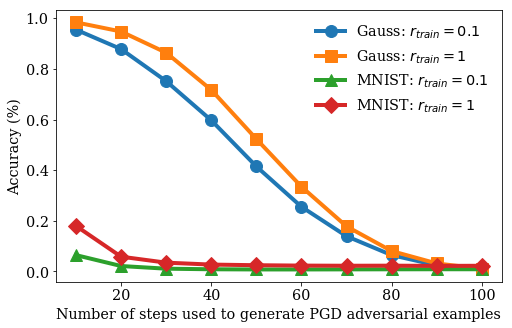

In [10]:
marker = itertools.cycle(('o', 's', '^', 'D', 'v', 'X', 'd', '+'))
labels = [r'Gauss: $r_{train}=0.1$', r'Gauss: $r_{train}=1$', 
          r'MNIST: $r_{train}=0.1$', r'MNIST: $r_{train}=1$']
plt.figure(figsize=(8, 5))
for i, acc in enumerate(acc_all):
    plt.plot(steps, acc, label=labels[i], marker=next(marker))
plt.xlabel('Number of steps used to generate PGD adversarial examples')
plt.ylabel('Accuracy (%)')
legend = plt.legend(fontsize='x-large', loc='upper right')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/mnist_gauss_train.pdf', bbox_inches='tight')
plt.show()

In [52]:
train

[[0.0004917106354493247, 0.9999333333333333, 0.011094897520777703, 0.9961],
 [0.0008956877431299949, 0.9998333333333334, 0.055006565226741806, 0.9864],
 [0.011197314531664598, 0.9962333333333333, 0.08738800471769519, 0.9791],
 [0.03969251252051132, 0.9868333333333333, 0.29941794978664255, 0.9274]]

In [6]:
model = build_dnn_wd(784, 1600, 4, out_dim=10)
model.load_weights('{}weights_mnist_{}-{}_train{}.h5'.format(out_path, 1600, 4, 1))

In [9]:
x_adv = PGD(model, x_test.reshape(-1, 784)[:200], 
            y_test[:200], grad_fn=None, norm="inf",
            n_step=20, step_size=0.01, target=False, init_rnd=0.)
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 100us/step


[25.16868476867676, 0.07]

--- 
## Adding Gaussian Noise

In [54]:
from keras.datasets import mnist

x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

path = './tmp/mnist_gauss/'

In [52]:
model_A = build_cnn_mnist()
model_B = build_cnn_mnist_2()
model_C = build_dnn_mnist(784, 300, 4)
model_D = build_dnn_mnist(784, 1200, 6)

In [13]:
train_acc = []
test_acc = []

for i, m in enumerate(['A', 'B', 'C', 'D']):
    if i == 0:
        model = build_cnn_mnist()
    elif i == 1:
        model = build_cnn_mnist_2()   
    elif i == 2:
        model = build_dnn_mnist(784, 300, 4)
    else:
        model = build_dnn_mnist(784, 1200, 6)
    
    model.load_weights('./tmp/weights/mnist_{}.h5'.format(m))
    train_acc.append(model.evaluate(x_train, y_train_cat, verbose=0)[1] * 100)
    test_acc.append(model.evaluate(x_test, y_test_cat, verbose=0)[1] * 100)

In [14]:
for a, b in zip(train_acc, test_acc):
    print('& {:.2f} & {:.2f} \\\\'.format(a, b))

& 99.82 & 99.09 \\
& 99.94 & 99.26 \\
& 99.23 & 97.90 \\
& 99.56 & 98.23 \\


In [53]:
model = model_D

In [35]:
std = 1

epochs = 100
batch_size = 128
n_batch = len(x_train) // batch_size
min_loss = np.inf

for epoch in range(epochs):
    ind = np.random.permutation(len(x_train))
    for batch in range(n_batch):
        b_ind = ind[batch * batch_size:(batch + 1) * batch_size]
        x, y = x_train[b_ind], y_train_cat[b_ind]
        # Add Gaussian noise
        x_t = x + np.random.normal(0, std, size=x.shape)
        
        model.train_on_batch(x_t, y)
    
    score = model.evaluate(x_test, y_test_cat, verbose=0)
    print('epoch: {} - {}'.format(epoch, score))
    val_loss = score[0]
    if val_loss < min_loss:
        min_loss = val_loss
        model.save_weights('./tmp.h5')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter == 5:
            break
    
model.load_weights('./tmp.h5')
print(model.evaluate(x_train, y_train_cat, verbose=0))
print(model.evaluate(x_test, y_test_cat, verbose=0))

epoch: 0 - [0.6251116827487946, 0.8448]
epoch: 1 - [0.4376235461473465, 0.8837]
epoch: 2 - [0.33528435881137847, 0.915]
epoch: 3 - [0.27753707238435743, 0.9328]
epoch: 4 - [0.23591122381091117, 0.9428]
epoch: 5 - [0.20205029751360418, 0.9494]
epoch: 6 - [0.17743048726320268, 0.9542]
epoch: 7 - [0.16312584053575993, 0.9573]
epoch: 8 - [0.1562374541401863, 0.9592]
epoch: 9 - [0.14787338250130416, 0.9606]
epoch: 10 - [0.1407295901209116, 0.9616]
epoch: 11 - [0.13787592879980803, 0.9615]
epoch: 12 - [0.13507719425708056, 0.9617]
epoch: 13 - [0.12627877158969641, 0.9639]
epoch: 14 - [0.12851692274659873, 0.9631]
epoch: 15 - [0.1228666020847857, 0.9655]
epoch: 16 - [0.12592043323516847, 0.9639]
epoch: 17 - [0.11795834875553847, 0.966]
epoch: 18 - [0.1159811177149415, 0.967]
epoch: 19 - [0.11663278012871742, 0.9673]
epoch: 20 - [0.1174728402003646, 0.9651]
epoch: 21 - [0.1140441600613296, 0.967]
epoch: 22 - [0.11549331450015307, 0.9651]
epoch: 23 - [0.1161523839764297, 0.9659]
epoch: 24 - [0.

In [126]:
model.save_weights('{}weights_test.h5'.format(path))

In [11]:
model.load_weights('./tmp/weights/mnist_A.h5')

In [33]:
adv_acc = pickle.load(open(path + 'adv_acc_baseline.p', 'rb'))
norm = pickle.load(open(path + 'x_adv_baseline.p', 'rb'))

In [39]:
adv_acc = np.array(adv_acc) * 100

In [45]:
for out, x_a in zip(adv_acc, norm):
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    string = ''
    for i in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(out[i], adv[i])
    string += '\\\\'
    print(string)

& 4.90\% (3.703) & 2.31\% (3.960) & 18.43\% (2.133) & 10.23\% (2.385) \\
& 10.10\% (3.518) & 7.53\% (3.727) & 21.33\% (2.020) & 12.85\% (2.250) \\
& 6.12\% (1.797) & 5.43\% (1.882) & 8.05\% (1.208) & 6.48\% (1.285) \\
& 15.86\% (1.790) & 14.66\% (1.943) & 16.43\% (1.279) & 16.08\% (1.295) \\


In [48]:
path = './tmp/mnist_gauss/'
adv_acc = pickle.load(open(path + 'adv_acc.p', 'rb'))
norm = pickle.load(open(path + 'x_adv.p', 'rb'))

In [51]:
adv_acc = np.array(adv_acc) * 100
for out, x_a in zip(adv_acc, norm):
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    string = ''
    for i in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(out[i], adv[i])
    string += '\\\\'
    print(string)
# model, std

& 4.44\% (4.218) & 2.48\% (4.398) & 12.68\% (2.232) & 6.71\% (2.399) \\
& 6.14\% (5.426) & 2.84\% (5.666) & 24.20\% (2.652) & 8.91\% (3.080) \\
& 2.53\% (5.447) & 0.42\% (5.590) & 23.90\% (2.601) & 4.20\% (3.210) \\
& 1.48\% (4.417) & 0.92\% (4.468) & 8.04\% (2.341) & 3.93\% (2.459) \\
& 8.81\% (5.736) & 2.99\% (6.125) & 31.63\% (2.668) & 17.14\% (3.082) \\
& 3.68\% (5.771) & 0.36\% (5.991) & 28.03\% (2.677) & 8.12\% (3.303) \\
& 8.24\% (2.181) & 5.11\% (2.665) & 9.01\% (1.490) & 7.86\% (1.549) \\
& 5.62\% (3.325) & 0.61\% (4.114) & 6.55\% (2.119) & 4.46\% (2.202) \\
& 5.66\% (3.313) & 0.36\% (4.095) & 8.03\% (2.075) & 4.22\% (2.229) \\
& 31.65\% (2.061) & 30.01\% (2.348) & 32.58\% (1.382) & 31.45\% (1.452) \\
& 8.07\% (3.714) & 3.59\% (4.361) & 10.61\% (2.332) & 6.54\% (2.507) \\
& 6.04\% (3.761) & 0.84\% (4.548) & 9.70\% (2.349) & 3.65\% (2.589) \\


In [55]:
model.load_weights('./tmp/mnist_gauss/weights_3_s0.1.h5')

In [65]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2", n_step=50,
                step_size=0.1, target=False, init_rnd=0., early_stop=True, proj='img')
ind = np.argmax(model.predict(x_adv), axis=1) != y_test[:200]
print(np.mean(np.linalg.norm((x_adv - x_test[:200])[ind].reshape(-1, 784), axis=1)))
print(model.evaluate(x_adv, y_test_cat[:200])[1])

1.3182708
200/200 [==============================] - 0s 91us/step
0.245


In [10]:
train_acc_all = []
test_acc_all = []

for i in range(4):
    if i == 0:
        model = build_cnn_mnist()
    elif i == 1:
        model = build_cnn_mnist_2()
    elif i == 2:
        model = build_dnn_mnist(784, 300, 4)
    else:
        model = build_dnn_mnist(784, 1200, 6)
    train_acc = []
    test_acc = []
    for s in [0.1, 0.5, 1.0]:
        model.load_weights('./tmp/mnist_gauss/weights_{}_s{}.h5'.format(i, s))
        train_acc.append(model.evaluate(x_train, y_train_cat, verbose=0)[1] * 100)
        test_acc.append(model.evaluate(x_test, y_test_cat, verbose=0)[1] * 100)
    train_acc_all.append(train_acc)
    test_acc_all.append(test_acc)

In [12]:
for train, test in zip(train_acc_all, test_acc_all):
    for a, b in zip(train, test):
        print('& {:.2f} & {:.2f} \\\\'.format(a, b))

& 99.68 & 99.13 \\
& 99.32 & 98.84 \\
& 98.24 & 97.96 \\
& 99.57 & 99.11 \\
& 99.64 & 99.20 \\
& 98.74 & 98.37 \\
& 99.26 & 98.12 \\
& 98.15 & 97.70 \\
& 97.16 & 96.66 \\
& 99.77 & 98.64 \\
& 99.24 & 98.52 \\
& 98.53 & 97.66 \\


---
## Regularization - MNIST

In [5]:
model_A = build_cnn_mnist()
model_B = build_cnn_mnist_2()
model_C = build_dnn_mnist(784, 300, 4)
model_D = build_dnn_mnist(784, 1200, 6)

In [29]:
model = build_cnn_mnist(reg='l2', lamda=1e-5)

In [20]:
model_D.load_weights('./tmp/mnist_reg/weights_3_l2_L1e-05.h5')
print(model_D.evaluate(x_train, y_train_cat))
print(model_D.evaluate(x_test, y_test_cat))

60000/60000 [==============================] - 4s 65us/step
[0.02209440834383616, 0.9938666666666667]
10000/10000 [==============================] - 1s 60us/step
[0.06877572418080236, 0.9816]


In [30]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(
    './tmp.h5', save_best_only=True, save_weights_only=True, period=1)
model.fit(x_train, y_train_cat,
          batch_size=128,
          epochs=100,
          verbose=1,
          callbacks=[earlystop, checkpoint],
          validation_data=(x_test, y_test_cat))
model.load_weights('./tmp.h5')
print(model.evaluate(x_train, y_train_cat))
print(model.evaluate(x_test, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.6422 - acc: 0.8130 - val_loss: 0.2142 - val_acc: 0.9401
Epoch 2/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.2630 - acc: 0.9241 - val_loss: 0.1351 - val_acc: 0.9598
Epoch 3/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.1912 - acc: 0.9456 - val_loss: 0.1006 - val_acc: 0.9690
Epoch 4/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.1506 - acc: 0.9570 - val_loss: 0.0797 - val_acc: 0.9749
Epoch 5/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.1291 - acc: 0.9639 - val_loss: 0.0691 - val_acc: 0.9797
Epoch 6/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.1101 - acc: 0.9693 - val_loss: 0.0605 - val_acc: 0.9820
Epoch 7/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0993 - acc: 0.9715 - val_loss: 0.0554 - 

In [31]:
model.save_weights('./tmp/mnist_reg/weights_0_l2_L1e-05.h5')

In [32]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2",
            n_step=50, step_size=0.1, target=False, init_rnd=0., proj='img', early_stop=True)
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 84us/step


[0.7130848360061646, 0.245]

In [8]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2",
            n_step=50, step_size=0.1, target=False, init_rnd=0., proj='img', early_stop=True)
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 187us/step


[0.6130856466293335, 0.355]

In [27]:
model.load_weights('./tmp/mnist_reg/weights_0_l2_L1e-06.h5')

In [28]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2",
            n_step=50, step_size=0.1, target=False, init_rnd=0., proj='img', early_stop=True)
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 930us/step


[0.6879241180419922, 0.27]

In [65]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2",
            n_step=100, step_size=0.1, target=False, init_rnd=0., proj='img', early_stop=True)
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 100us/step


[1.9917819213867187, 0.0]

In [15]:
path = './tmp/mnist_reg/'
out_all = pickle.load(open(path + 'adv_acc_4.p', 'rb'))
norm = pickle.load(open(path + 'norm_4.p', 'rb'))

In [8]:
out = np.array(out_all) * 100
for i in [0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]: 
    print('& {:.2f}\\% & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% \\\\'.format(*out[i]))

& 0.00\% & 0.00\% & 1.77\% & 0.00\% \\
& 4.07\% & 2.47\% & 24.95\% & 16.96\% \\
& 4.70\% & 2.89\% & 29.55\% & 21.76\% \\
& 0.00\% & 0.00\% & 1.71\% & 0.00\% \\
& 4.19\% & 3.17\% & 24.80\% & 18.20\% \\
& 9.40\% & 6.51\% & 40.33\% & 35.28\% \\
& 0.00\% & 0.00\% & 0.49\% & 0.00\% \\
& 5.98\% & 2.24\% & 8.47\% & 6.38\% \\
& 11.40\% & 7.42\% & 20.33\% & 18.96\% \\
& 0.00\% & 0.00\% & 0.98\% & 0.00\% \\
& 13.27\% & 9.41\% & 17.58\% & 14.92\% \\
& 27.39\% & 24.86\% & 29.07\% & 28.32\% \\


In [13]:
path = './tmp/mnist_reg/'
out_all = pickle.load(open(path + 'adv_acc_5.p', 'rb'))
norm = pickle.load(open(path + 'norm_5.p', 'rb'))

In [10]:
out = np.array(out_all) * 100
for i in [0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]: 
    print('& {:.2f}\\% & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% \\\\'.format(*out[i]))

& 1.18\% & 0.00\% & 18.12\% & 1.38\% \\
& 2.71\% & 1.52\% & 24.55\% & 16.64\% \\
& 3.20\% & 1.22\% & 24.14\% & 16.33\% \\
& 0.78\% & 0.00\% & 18.20\% & 1.23\% \\
& 3.25\% & 2.04\% & 22.92\% & 14.70\% \\
& 4.90\% & 3.72\% & 37.18\% & 30.47\% \\
& 0.13\% & 0.00\% & 8.65\% & 1.02\% \\
& 3.94\% & 0.30\% & 9.07\% & 7.01\% \\
& 6.07\% & 4.92\% & 9.26\% & 7.51\% \\
& 11.35\% & 11.35\% & 11.35\% & 11.35\% \\
& 6.44\% & 0.80\% & 17.48\% & 13.89\% \\
& 13.34\% & 12.79\% & 15.78\% & 13.98\% \\


In [16]:
for x_a in norm:
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    print(adv)

[3.466027, 3.466027, 2.097997, 2.1531568]
[2.7239463, 2.7239463, 2.0254414, 2.0749388]
[2.4687166, 2.4687166, 1.528845, 1.5462861]
[2.4863017, 2.4863017, 1.5848464, 1.6188873]
[3.7136474, 3.8555164, 1.9378282, 2.0852458]
[3.248454, 3.3283625, 1.8236632, 1.9441906]
[2.2057667, 2.7210798, 1.3818226, 1.4536977]
[2.432264, 3.0246167, 1.4410797, 1.5258893]
[3.695662, 3.8606808, 1.8941284, 2.052534]
[4.077711, 4.349017, 1.6974311, 1.7896813]
[2.0591614, 2.5279837, 1.1193666, 1.2045435]
[1.9463419, 2.3005285, 1.2261314, 1.2695005]


In [5]:
path = './tmp/mnist_reg/'
out_all = pickle.load(open(path + 'adv_acc_2.p', 'rb'))
norm = pickle.load(open(path + 'norm_2.p', 'rb'))

In [6]:
out_all

[[0.0524, 0.0323, 0.3301, 0.2639], [0.0166, 0.0115, 0.1367, 0.0754]]

In [21]:
path = './tmp/mnist_reg/'
out_all = pickle.load(open(path + 'adv_acc_7.p', 'rb'))
norm = pickle.load(open(path + 'norm_7.p', 'rb'))

In [22]:
out_all

[[0.0524, 0.0323, 0.3301, 0.2639], [0.0166, 0.0115, 0.1367, 0.0754]]

In [23]:
for x_a in norm:
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    print(adv)

[3.8966942, 4.079552, 1.7485583, 1.8703465]
[3.740661, 3.7834938, 2.0219855, 2.1215885]


---
## Adversarial Training

In [21]:
path = './tmp/mnist_adv/'
adv_acc = pickle.load(open(path + 'adv_acc.p', 'rb'))
norm = pickle.load(open(path + 'norm.p', 'rb'))

In [71]:
adv_acc = np.array(adv_acc) * 100
for out, x_a in zip(adv_acc, norm):
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    string = ''
    for i in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(out[i], adv[i])
    string += '\\\\'
    print(string)
# model, std

& 18.09\% (3.808) & 7.69\% (4.556) & 80.35\% (1.157) & 78.42\% (1.246) \\
& 19.92\% (4.363) & 7.34\% (5.486) & 91.05\% (0.632) & 90.16\% (0.700) \\
& 28.41\% (2.268) & 23.71\% (2.973) & 47.67\% (1.004) & 46.61\% (1.095) \\
& 24.43\% (1.916) & 22.25\% (2.260) & 67.74\% (0.990) & 65.96\% (1.118) \\


In [48]:
model = ['A', 'B', 'C', 'D']
out = np.array(out_all) * 100
for m, o in zip(model, out):
    print('{} & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% \\\\'.format(m, *o))

A & 18.09\% & 7.69\% & 80.35\% & 78.42\% \\
B & 19.92\% & 7.34\% & 91.05\% & 90.16\% \\
C & 28.41\% & 23.71\% & 47.67\% & 46.61\% \\
D & 24.43\% & 22.25\% & 67.74\% & 65.96\% \\


In [50]:
for n in norm:
    adv = []
    for m in n:
        adv.append(np.mean(m))
    print(adv)

[3.8081129, 4.5558825, 1.1571115, 1.2459921]
[4.362948, 5.485732, 0.6317042, 0.6999941]
[2.2682433, 2.9729567, 1.0037736, 1.0949409]
[1.9159247, 2.2598581, 0.99010086, 1.1183044]


In [15]:
train_acc = []
test_acc = []

for i, m in enumerate(['A', 'B', 'C', 'D']):
    if i == 0:
        model = build_cnn_mnist()
    elif i == 1:
        model = build_cnn_mnist_2()   
    elif i == 2:
        model = build_dnn_mnist(784, 300, 4)
    else:
        model = build_dnn_mnist(784, 1200, 6)
    
    model.load_weights('./tmp/adv_train/weights_{}_mnist_40-0.01.h5'.format(m))
    train_acc.append(model.evaluate(x_train, y_train_cat, verbose=0)[1] * 100)
    test_acc.append(model.evaluate(x_test, y_test_cat, verbose=0)[1] * 100)

In [16]:
for a, b in zip(train_acc, test_acc):
    print('& {:.2f} & {:.2f} \\\\'.format(a, b))

& 99.99 & 99.30 \\
& 100.00 & 99.18 \\
& 99.48 & 98.05 \\
& 99.14 & 98.03 \\


## MNIST Hinge

In [22]:
path = './tmp/mnist_hinge/'
out_all = pickle.load(open(path + 'adv_acc.p', 'rb'))
norm = pickle.load(open(path + 'norm.p', 'rb'))

In [23]:
adv_acc = np.array(out_all) * 100
for out, x_a in zip(adv_acc, norm):
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    string = ''
    for i in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(out[i], adv[i])
    string += '\\\\'
    print(string)

& 4.77\% (3.490) & 3.67\% (3.583) & 22.59\% (2.245) & 13.04\% (2.571) \\
& 98.12\% (0.318) & 98.12\% (0.318) & 98.85\% (0.089) & 98.83\% (0.089) \\
& 99.10\% (0.206) & 99.10\% (0.206) & 99.10\% (0.079) & 99.10\% (0.079) \\
& 10.31\% (3.076) & 7.70\% (3.306) & 33.54\% (1.928) & 23.69\% (2.325) \\
& 98.85\% (0.206) & 98.85\% (0.206) & 99.13\% (0.084) & 99.13\% (0.084) \\
& 99.07\% (0.207) & 99.07\% (0.207) & 99.08\% (0.085) & 99.08\% (0.085) \\
& 0.05\% (1.838) & 0.00\% (1.844) & 0.46\% (1.316) & 0.07\% (1.334) \\
& 97.54\% (0.217) & 97.54\% (0.217) & 98.20\% (0.073) & 98.20\% (0.073) \\
& 98.24\% (0.205) & 98.24\% (0.205) & 98.24\% (0.070) & 98.24\% (0.070) \\
& 0.04\% (2.129) & 0.01\% (2.132) & 0.17\% (1.484) & 0.02\% (1.490) \\
& 97.66\% (0.225) & 97.66\% (0.225) & 98.26\% (0.074) & 98.26\% (0.074) \\
& 98.26\% (0.206) & 98.26\% (0.206) & 98.26\% (0.075) & 98.26\% (0.075) \\


In [18]:
out_all

[[0.0477, 0.0367, 0.2259, 0.1304],
 [0.9812, 0.9812, 0.9885, 0.9883],
 [0.991, 0.991, 0.991, 0.991],
 [0.1031, 0.077, 0.3354, 0.2369],
 [0.9885, 0.9885, 0.9913, 0.9913],
 [0.9907, 0.9907, 0.9908, 0.9908],
 [0.0005, 0.0, 0.0046, 0.0007],
 [0.9754, 0.9754, 0.982, 0.982],
 [0.9824, 0.9824, 0.9824, 0.9824],
 [0.0004, 0.0001, 0.0017, 0.0002],
 [0.9766, 0.9766, 0.9826, 0.9826],
 [0.9826, 0.9826, 0.9826, 0.9826]]

In [19]:
#model = ['A', 'B', 'C', 'D']
out = np.array(out_all) * 100
for o in out:
    print('& & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% \\\\'.format(*o))

& 4.77\% & 3.67\% & 22.59\% & 13.04\% \\
& 98.12\% & 98.12\% & 98.85\% & 98.83\% \\
& 99.10\% & 99.10\% & 99.10\% & 99.10\% \\
& 10.31\% & 7.70\% & 33.54\% & 23.69\% \\
& 98.85\% & 98.85\% & 99.13\% & 99.13\% \\
& 99.07\% & 99.07\% & 99.08\% & 99.08\% \\
& 0.05\% & 0.00\% & 0.46\% & 0.07\% \\
& 97.54\% & 97.54\% & 98.20\% & 98.20\% \\
& 98.24\% & 98.24\% & 98.24\% & 98.24\% \\
& 0.04\% & 0.01\% & 0.17\% & 0.02\% \\
& 97.66\% & 97.66\% & 98.26\% & 98.26\% \\
& 98.26\% & 98.26\% & 98.26\% & 98.26\% \\


In [13]:
model = build_cnn_mnist()
model.load_weights('./tmp/mnist_a_hinge_c1e4/model.h5')

In [14]:
grad_fn = gradient_fn(model, fn='mse')
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=grad_fn, norm="2", n_step=100,
                step_size=0.1, target=False, init_rnd=0, early_stop=True, proj='img')
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 492us/step


[3.3896484375, 0.99]

In [60]:
np.mean(np.linalg.norm((x_test[:200] - x_adv).reshape((-1, 784)), axis=1))

0.7449348

In [20]:
for n in norm:
    tmp = []
    for m in n:
        tmp.append(np.mean(m))
    print(tmp)

[3.4899096, 3.583348, 2.2446651, 2.5708919]
[0.31761956, 0.31761956, 0.08887988, 0.08942088]
[0.20621184, 0.20621184, 0.078597784, 0.078597784]
[3.075867, 3.305542, 1.927946, 2.324614]
[0.20608595, 0.20608595, 0.08394684, 0.08394684]
[0.20678778, 0.20678778, 0.085187994, 0.08518799]
[1.8379561, 1.843642, 1.3160349, 1.3336991]
[0.21748272, 0.21748272, 0.07320984, 0.07320984]
[0.2054545, 0.2054545, 0.070391946, 0.070391946]
[2.12854, 2.1317558, 1.4835951, 1.4902529]
[0.22533785, 0.22533785, 0.073872164, 0.073872164]
[0.20605744, 0.20605744, 0.07450759, 0.07450759]


In [92]:
opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test[:100])
norm = np.zeros(100)

for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_a_hinge_c1/model.h5', 
                                         n_step=1000, prog=False)

834 1.249677
955 1.0085694
688 0.87732315
961 1.0266873
403 0.473719
357 0.46422395
646 1.6913913
835 1.5604444
683 1.7266155
610 0.7848365
815 1.5394458
771 1.6924123
562 1.115763
577 1.2391906
853 1.4778733
584 0.34626687
664 1.3739657
631 1.0673243
601 1.3017255
781 1.7501563
508 0.9494593
605 1.4051365
838 1.4699451
730 1.5199435
671 0.920124
478 0.99887663
427 1.3910831
652 1.1353099
952 1.5259749
565 0.97829425
489 1.2699574
977 1.3346845
747 1.1208651
865 0.88325137
722 0.8242347
795 0.65399235
717 1.0098903
663 0.93388575
469 1.1722908
451 1.2835174
757 1.8556249
419 0.5876409
821 1.2211102
648 1.7742425
932 1.7079213
512 1.1397663
685 1.9748063
674 1.3481584
509 1.4811864
827 0.8413359
707 1.3226146
420 0.76849604
787 1.4434363
500 0.34278885
739 0.6183671
825 1.434292
467 0.876911
706 1.3783139
600 0.740553
684 1.4701891
663 1.4078088
932 1.9833622
450 1.5085076
792 0.8745393
959 1.165659
679 1.414678
439 1.3986557
527 0.78746235
356 0.83332753
477 0.5301823
632 1.7328244
803

In [85]:
opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

i = 14
x_adv, norm = opt.optimize(x_test[i], y_test_cat[i], 
                           './tmp/mnist_a_hinge_c1/model.h5', 
                           n_step=1000, prog=True)

Step: 0, norm=0.215, loss=8.768, obj=8.984
Step: 50, norm=1.581, loss=5.409, obj=6.990
Step: 100, norm=2.114, loss=0.000, obj=2.114
Step: 150, norm=2.025, loss=0.000, obj=2.025
Step: 200, norm=2.055, loss=0.000, obj=2.055
Step: 250, norm=1.872, loss=0.000, obj=1.872
Step: 300, norm=1.821, loss=0.019, obj=1.840
Step: 350, norm=1.800, loss=0.000, obj=1.800
Step: 400, norm=1.768, loss=0.000, obj=1.768
Step: 450, norm=1.761, loss=0.000, obj=1.761
Step: 500, norm=1.708, loss=0.088, obj=1.796
Step: 550, norm=1.698, loss=0.024, obj=1.722
Step: 600, norm=1.693, loss=0.088, obj=1.781
Step: 650, norm=1.728, loss=0.000, obj=1.728
Step: 700, norm=1.731, loss=0.000, obj=1.731
Step: 750, norm=1.760, loss=0.000, obj=1.760
771 1.6924123


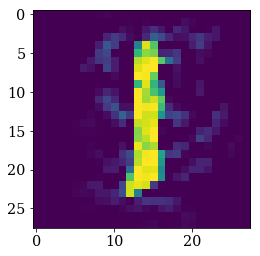

In [87]:
plt.imshow(x_adv.reshape(28, 28))

In [93]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 0s 2ms/step


[0.8083432149887085, 0.0]

In [95]:
np.mean(norm)

1.2061219992488623

In [51]:
path = './tmp/mnist_hinge/'
out_all = []
norm = []
out_all.append(pickle.load(open(path + 'adv_acc_cw_a.p', 'rb')))
norm.append(pickle.load(open(path + 'norm_cw_a.p', 'rb')))
out_all.append(pickle.load(open(path + 'adv_acc_cw_b.p', 'rb')))
norm.append(pickle.load(open(path + 'norm_cw_b.p', 'rb')))
out_all.append(pickle.load(open(path + 'adv_acc_cw_c.p', 'rb')))
norm.append(pickle.load(open(path + 'norm_cw_c.p', 'rb')))
out_all.append(pickle.load(open(path + 'adv_acc_cw_d.p', 'rb')))
norm.append(pickle.load(open(path + 'norm_cw_d.p', 'rb')))
out_all = np.array(out_all)
norm = np.array(norm)

In [52]:
out_all

array([[0.0015, 0.    , 0.    ],
       [0.001 , 0.0005, 0.    ],
       [0.0005, 0.    , 0.    ],
       [0.4355, 0.    , 0.    ]])

In [53]:
for n in norm:
    tmp = []
    for m in n:
        tmp.append(np.mean(m))
    print(tmp)

[1.2597697622869788, 3.2441625574416246, 5.626747233669507]
[1.0124896123609808, 3.157218853380956, 5.562136739145906]
[0.975609056695037, 2.888066176317399, 5.152594895969611]
[1.1216221650436675, 2.8534364917376878, 5.214344760305015]


In [58]:
adv_acc = np.array(out_all) * 100
for out, x_a in zip(adv_acc, norm):
    adv = []
    for x in x_a:
        adv.append(np.mean(x))
    string = ''
    for i in range(3):
        string += '& {:.2f}\\% ({:.3f}) '.format(out[i], adv[i])
    string += '\\\\'
    print(string)

& 0.15\% (1.260) & 0.00\% (3.244) & 0.00\% (5.627) \\
& 0.10\% (1.012) & 0.05\% (3.157) & 0.00\% (5.562) \\
& 0.05\% (0.976) & 0.00\% (2.888) & 0.00\% (5.153) \\
& 43.55\% (1.122) & 0.00\% (2.853) & 0.00\% (5.214) \\


In [27]:
print(pickle.load(open(path + 'adv_acc_cw_d_2.p', 'rb')))
norm = pickle.load(open(path + 'norm_cw_d_2.p', 'rb'))

[0.0]


In [28]:
np.mean(norm)

2.177731128770276

In [5]:
acc = []
for m in ['a', 'b', 'c', 'd']:

    if m == 'a':
        model = build_cnn_mnist()
    elif m == 'b':
        model = build_cnn_mnist_2()
    elif m == 'c':
        model = build_dnn_mnist(784, 300, 4)
    else:
        model = build_dnn_mnist(784, 1200, 6)

    for C in ['1', '1e2', '1e4']:

        model.load_weights('./tmp/mnist_{}_hinge_c{}/model.h5'.format(m, C))
        acc.append(model.evaluate(x_train, y_train_cat)[1])
        acc.append(model.evaluate(x_test, y_test_cat)[1])

10000/10000 [==============================] - 0s 50us/step


In [12]:
for i in range(0, len(acc), 2):
    print('&  & {:.2f} & {:.2f} \\\\'.format(acc[i]*100, acc[i+1]*100))

&  & 99.77 & 99.30 \\
&  & 99.67 & 99.09 \\
&  & 99.64 & 99.11 \\
&  & 99.98 & 99.37 \\
&  & 99.99 & 99.25 \\
&  & 99.84 & 99.08 \\
&  & 99.22 & 97.88 \\
&  & 99.63 & 98.41 \\
&  & 99.61 & 98.24 \\
&  & 99.09 & 98.01 \\
&  & 99.71 & 98.40 \\
&  & 99.50 & 98.26 \\


## MNIST Margin

In [7]:
model = build_cnn_mnist()
weight_path = './tmp/mnist_a_margin_c1e4_l1/model.h5'
model.load_weights(weight_path)

In [41]:
x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2", n_step=50,
                step_size=0.1, target=False, init_rnd=0., early_stop=True, proj='img')
model.evaluate(x_adv, y_test_cat[:200])

200/200 [==============================] - 0s 2ms/step


[0.33224853515625, 0.995]

In [42]:
model.predict(x_test[:3])

array([[1145.8126 ,  670.1632 , 1085.8052 , 1177.4717 ,  798.5478 ,
        1021.3019 ,  408.73645, 1679.8677 , 1168.2714 , 1157.1459 ],
       [1343.5153 , 1570.4952 , 2023.2434 , 1218.5148 ,  786.3806 ,
         880.0475 , 1260.1282 ,  939.68207, 1065.7428 ,  846.4018 ],
       [ 429.84335,  697.86206,  400.6856 ,  309.1889 ,  479.19394,
         286.99948,  355.9588 ,  391.09897,  408.78375,  300.49057]],
      dtype=float32)

In [43]:
np.mean(np.linalg.norm((x_adv - x_test[:200]).reshape(-1, 784), axis=1))

0.00040482354

In [8]:
opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test[:100])
norm = np.zeros(100)

for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         weight_path, 
                                         n_step=1000, prog=False)

In [9]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 0s 2ms/step


[31874.501953125, 0.0]

In [10]:
np.mean(norm[np.logical_not(np.isnan(norm))])

5.434279597997666

In [69]:
model = build_cnn_mnist()
model.load_weights('./tmp/mnist_a_margin_c1_l1e-1/model.h5')

opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test[:100])
norm = np.zeros(100)

for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_a_margin_c1_l1e-1/model.h5', 
                                         n_step=1000, prog=False)

744 2.0976593
680 1.4234893
685 1.0837396
854 1.3824831
822 0.88617533
427 1.3765026
604 1.0581111
584 1.6073186
920 1.6673732
563 1.8580561
614 1.146233
784 1.6139787
801 1.0290034
531 0.42269847
664 1.5942067
485 1.287493
480 1.381505
848 1.4288517
603 1.8513505
513 1.1680964
583 2.00475
618 1.2472271
567 1.564692
900 1.4698888
653 1.5241773
989 1.8209057
531 1.3541716
903 1.7546698
624 1.3804842
623 2.0396028
739 2.2753258
872 1.1168981
979 1.5000628
630 1.6409396
592 1.1835889
380 0.7829149
763 1.3537356
360 0.9672389
529 1.4134364
594 2.572223
390 0.7130056
801 1.3611034
814 1.6742055
789 1.9146276
859 1.268057
682 2.1516047
465 1.569587
445 1.6547742
498 1.8234901
579 0.9257151
743 1.6210896
711 1.7517837
469 0.7394538
536 0.6107891
552 2.2891004
597 0.9878317
367 1.5816675
628 1.1373577
561 1.4323629
955 2.0402324
825 1.9668934
477 0.9501202
849 2.139251
524 1.384037
860 1.8868606
463 0.95960486
828 2.1473489
427 0.8000736
778 2.3824108
576 1.2443228
543 2.061536
336 1.4696071
6

In [70]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 1s 8ms/step


[0.7449737215042114, 0.04]

In [71]:
np.mean(norm[np.logical_not(np.isnan(norm))])

1.4323890718072654

In [27]:
path = './tmp/mnist_margin/'
adv = pickle.load(open(path + 'adv_acc_cw_0_c1e2.p', 'rb'))
norm = pickle.load(open(path + 'norm_cw_0_c1e2.p', 'rb'))
norm = [np.mean(n) for n in norm]
string = ''
for i in range(len(adv)):
    string += '\n & {:.2f}\\% & {:.3f} \\\\'.format(adv[i] * 100, norm[i])
print(string)


 & 9.75\% & 0.005 \\
 & 0.00\% & 1.885 \\


In [28]:
path = './tmp/mnist_margin/'
adv = pickle.load(open(path + 'adv_acc_cw_0_c1e2_2.p', 'rb'))
norm = pickle.load(open(path + 'norm_cw_0_c1e2_2.p', 'rb'))
norm = [np.mean(n) for n in norm]
string = ''
for i in range(len(adv)):
    string += '\n & {:.2f}\\% & {:.3f} \\\\'.format(adv[i] * 100, norm[i])
print(string)


 & 0.00\% & 2.843 \\
 & 0.00\% & 2.752 \\
 & 0.00\% & 2.888 \\


In [16]:
path = './tmp/mnist_margin/'
adv = pickle.load(open(path + 'adv_acc_0_c1e2_pgd.p', 'rb'))
norm = pickle.load(open(path + 'norm_0_c1e2_pgd.p', 'rb'))
norm = [[np.mean(m) for m in n] for n in norm]
string = ''
for i in range(len(adv)):
    string += '\n'
    for j in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(adv[i][j] * 100, norm[i][j])
string += '\\\\'
print(string)


& 97.15\% (0.333) & 97.15\% (0.333) & 98.52\% (0.088) & 98.49\% (0.088) 
& 97.79\% (0.269) & 97.79\% (0.269) & 98.65\% (0.086) & 98.63\% (0.086) 
& 97.15\% (0.418) & 97.15\% (0.418) & 98.50\% (0.087) & 98.50\% (0.087) \\


In [17]:
path = './tmp/mnist_margin/'
adv = pickle.load(open(path + 'adv_acc_0_c1e2_pgd_2.p', 'rb'))
norm = pickle.load(open(path + 'norm_0_c1e2_pgd_2.p', 'rb'))
norm = [[np.mean(m) for m in n] for n in norm]
string = ''
for i in range(len(adv)):
    string += '\n'
    for j in range(4):
        string += '& {:.2f}\\% ({:.3f}) '.format(adv[i][j] * 100, norm[i][j])
string += '\\\\'
print(string)


& 9.82\% (0.232) & 9.68\% (0.255) & 9.82\% (0.087) & 9.82\% (0.087) 
& 67.22\% (0.441) & 67.18\% (0.450) & 76.42\% (0.091) & 76.32\% (0.091) \\


In [6]:
path = './tmp/mnist_margin/'
print(pickle.load(open(path + 'adv_acc_cw_a_c1e2.p', 'rb')))
norm = pickle.load(open(path + 'norm_cw_a_c1e2.p', 'rb'))
[np.mean(n) for n in norm]

[0.0, 0.0, 0.001]


[2.8292246243220287, 3.096051563514164, 2.8196359638544686]

In [ ]:
# large c means larger dist but gradient seems to be large as well
# large l means smaller gradient

In [6]:
path = './tmp/mnist_margin/'
acc = pickle.load(open('./tmp/mnist_margin/acc_1.p', 'rb'))

In [7]:
acc

[0.10218333333333333, 0.101]

In [14]:
train_test_acc = []
for C in [1, 1e2, 1e4]:
    for lamda in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
        
        path = './tmp/mnist_0_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        train_test_acc.append(model.evaluate(x_train, y_train_cat)[1])
        train_test_acc.append(model.evaluate(x_test, y_test_cat)[1])

10000/10000 [==============================] - 1s 83us/step


In [15]:
i = 0
for C in [1, 1e2, 1e4]:
    for lamda in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
        print('{} & {} & {:.2f} & {:.2f}'.format(C, lamda, 
                                                 train_test_acc[2*i] * 100, 
                                                 train_test_acc[2*i + 1] * 100))
        i += 1

1 & 1e-08 & 99.60 & 98.98
1 & 1e-07 & 99.76 & 98.93
1 & 1e-06 & 99.70 & 98.88
1 & 1e-05 & 99.31 & 98.88
1 & 0.0001 & 94.14 & 94.48
1 & 0.001 & 9.86 & 9.58
1 & 0.01 & 19.95 & 20.40
1 & 0.1 & 9.92 & 10.09
1 & 1 & 9.75 & 9.74
100.0 & 1e-08 & 99.45 & 98.73
100.0 & 1e-07 & 99.57 & 98.88
100.0 & 1e-06 & 99.83 & 98.97
100.0 & 1e-05 & 99.54 & 98.85
100.0 & 0.0001 & 99.55 & 98.72
100.0 & 0.001 & 46.10 & 46.02
100.0 & 0.01 & 10.43 & 10.30
100.0 & 0.1 & 9.72 & 9.80
100.0 & 1 & 9.75 & 9.74
10000.0 & 1e-08 & 99.52 & 98.70
10000.0 & 1e-07 & 99.23 & 98.52
10000.0 & 1e-06 & 99.62 & 98.74
10000.0 & 1e-05 & 99.62 & 98.61
10000.0 & 0.0001 & 99.04 & 98.55
10000.0 & 0.001 & 54.99 & 55.23
10000.0 & 0.01 & 18.06 & 18.24
10000.0 & 0.1 & 10.44 & 10.28
10000.0 & 1 & 9.04 & 8.92


In [13]:
#2
i = 0
for C in [1, 1e2, 1e4]:
    for lamda in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
        print('{} & {} & {:.2f} & {:.2f}'.format(C, lamda, 
                                                 train_test_acc[2*i] * 100, 
                                                 train_test_acc[2*i + 1] * 100))
        i += 1

1 & 1e-08 & 99.73 & 98.94
1 & 1e-07 & 98.74 & 98.41
1 & 1e-06 & 67.89 & 67.00
1 & 1e-05 & 68.52 & 68.46
1 & 0.0001 & 13.15 & 13.49
1 & 0.001 & 27.92 & 28.48
1 & 0.01 & 9.86 & 9.58
1 & 0.1 & 10.44 & 10.28
1 & 1 & 9.93 & 10.32
100.0 & 1e-08 & 99.74 & 98.90
100.0 & 1e-07 & 95.19 & 95.28
100.0 & 1e-06 & 78.57 & 78.77
100.0 & 1e-05 & 41.66 & 43.19
100.0 & 0.0001 & 19.00 & 19.05
100.0 & 0.001 & 9.87 & 9.80
100.0 & 0.01 & 9.87 & 9.58
100.0 & 0.1 & 9.75 & 9.74
100.0 & 1 & 9.03 & 8.92
10000.0 & 1e-08 & 99.64 & 98.63
10000.0 & 1e-07 & 98.82 & 98.27
10000.0 & 1e-06 & 97.69 & 97.65
10000.0 & 1e-05 & 61.53 & 62.84
10000.0 & 0.0001 & 13.15 & 13.66
10000.0 & 0.001 & 11.24 & 11.36
10000.0 & 0.01 & 10.22 & 10.10
10000.0 & 0.1 & 11.24 & 11.35
10000.0 & 1 & 10.22 & 10.10


In [ ]:
for C in [1, 1e2, 1e4]:
    for lamda in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
        
        path = './tmp/mnist_0_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
#         x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2", n_step=50,
#                 step_size=0.1, target=False, init_rnd=0., early_stop=True, proj='img')
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

1 1e-08
100/100 [==============================] - 1s 6ms/step
[0.7665975379943848, 0.0]
1.198652681335807


1 1e-07
100/100 [==============================] - 1s 7ms/step
[0.7297619724273682, 0.0]
1.1501960013061763


1 1e-06
100/100 [==============================] - 1s 10ms/step
[0.7763922476768493, 0.0]
1.1546933438442648


1 1e-05
100/100 [==============================] - 1s 10ms/step
[0.840819640159607, 0.0]
1.4016218279115855


1 0.0001
100/100 [==============================] - 1s 13ms/step
[0.9358652687072754, 0.01]
1.4178136832267045


100.0 1e-08
100/100 [==============================] - 2s 16ms/step
[2.4843095207214354, 0.0]
2.7985320806503298


100.0 1e-07
100/100 [==============================] - 2s 18ms/step
[3.769030156135559, 0.0]
2.74230490044225


100.0 1e-06
100/100 [==============================] - 2s 23ms/step
[5.6684349203109745, 0.0]
2.6979609151929616


100.0 1e-05
100/100 [==============================] - 2s 21ms/step
[0.8400825309753418, 0.0]
2.455794389

In [5]:
for C in [1e4]:
    for lamda in [1e-6, 1e-5, 1e-4]:
        
        path = './tmp/mnist_0_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
#         x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2", n_step=50,
#                 step_size=0.1, target=False, init_rnd=0., early_stop=True, proj='img')
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

10000.0 1e-06
100/100 [==============================] - 0s 823us/step
[37708.47390625, 0.0]
4.56059256516397


10000.0 1e-05
100/100 [==============================] - 0s 1ms/step
[37574.60671875, 0.0]
4.733556143045425


10000.0 0.0001
100/100 [==============================] - 0s 1ms/step
[25737.76890625, 0.0]
4.761446526050568




In [13]:
for C in ['1e2']:
    for lamda in ['1e-1', 1, '1e1']:
        
        path = './tmp/mnist_a_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
#         x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="2", n_step=50,
#                 step_size=0.1, target=False, init_rnd=0., early_stop=True, proj='img')
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

1e2 1e-1
100/100 [==============================] - 0s 3ms/step
[1.115299298763275, 0.0]
2.8013450357317926


1e2 1
100/100 [==============================] - 0s 3ms/step
[1.390903151035309, 0.0]
3.0650123450299724


1e2 1e1
100/100 [==============================] - 0s 4ms/step
[1.0216299629211425, 0.0]
2.870854597017169




In [15]:
for C in [1, 1e2, 1e4]:
    for lamda in [1e-8, 1e-7, 1e-6]:
        
        path = './tmp/mnist_0_margin_c{}_l{}_2/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

1 1e-08
100/100 [==============================] - 1s 7ms/step
[0.7749014210700989, 0.0]
1.2698889727145433


1 1e-07
100/100 [==============================] - 1s 8ms/step
[0.8966481113433837, 0.0]
1.218768122792244


1 1e-06
100/100 [==============================] - 1s 12ms/step
[1.4161449623107911, 0.01]
0.640521601724904


100.0 1e-08
100/100 [==============================] - 1s 13ms/step
[7.748566370010376, 0.0]
2.829295699899085


100.0 1e-07
100/100 [==============================] - 2s 16ms/step
[5.625596179962158, 0.0]
2.5516858717706055


100.0 1e-06
100/100 [==============================] - 2s 18ms/step
[20.169281721115112, 0.0]
1.971486208755523


10000.0 1e-08
100/100 [==============================] - 2s 20ms/step
[39639.9259375, 0.0]
4.647837112769484


10000.0 1e-07
100/100 [==============================] - 2s 21ms/step
[27615.072734375, 0.0]
4.768170896922238


10000.0 1e-06
100/100 [==============================] - 2s 23ms/step
[20880.52171875, 0.0]
4.96213555112

In [ ]:
# square but file name doesnt have _2
for C in ['1e2']:
    for lamda in ['1e-10', '1e-12', '1e-14', '1e-16', '1e-18', '1e-20', 
                 '1e-22', '1e-24']:
        
        path = './tmp/mnist_0_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

1e2 1e-10
100/100 [==============================] - 3s 26ms/step
[0.8474851775169373, 0.0]
2.8101647889614103


1e2 1e-12
100/100 [==============================] - 3s 27ms/step
[0.8462567973136902, 0.0]
2.7255279180407523


1e2 1e-14
100/100 [==============================] - 3s 33ms/step
[2.8178737354278565, 0.0]
2.7057058642432095


1e2 1e-16
100/100 [==============================] - 3s 32ms/step
[3.4454725122451784, 0.0]
2.8033681517094373


1e2 1e-18
100/100 [==============================] - 4s 36ms/step
[1.7928581714630127, 0.0]
2.8278158891201017


1e2 1e-20
100/100 [==============================] - 4s 37ms/step
[1.4956170129776, 0.0]
2.856091097667813




In [17]:
# square but file name doesnt have _2
for C in ['1e2']:
    for lamda in ['1e-22', '1e-24']:
        
        path = './tmp/mnist_0_margin_c{}_l{}/'.format(C, lamda)
        model = build_cnn_mnist()
        model.load_weights(path + 'model.h5')
        
        opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

        x_adv = np.zeros_like(x_test[:100])
        norm = np.zeros(100)

        for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
            y_pred = predict(model, x)
            if y_pred is not np.argmax(y):
                x_adv[i], norm[i] = opt.optimize(x, y, 
                                                 path + 'model.h5', 
                                                 n_step=1000, prog=False)
        print(C, lamda)
        print(model.evaluate(x_adv, y_test_cat[:100]))
        print(np.mean(norm[np.logical_not(np.isnan(norm))]))
        print('\n')

1e2 1e-22
100/100 [==============================] - 5s 53ms/step
[2.729799175262451, 0.0]
2.6238374414294956




OSError: Unable to open file (Unable to open file: name = './tmp/mnist_0_margin_c1e2_l1e-24/model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [19]:
path = './tmp/mnist_a_hinge_c1e2/'
model = build_cnn_mnist()
model.load_weights(path + 'model.h5')

opt = OptCarlini(model, target=False, c=1, lr=0.1, init_scl=0.,
         use_bound=False, loss_op=0, k=0, var_change=True,
         use_mask=False)

x_adv = np.zeros_like(x_test[:100])
norm = np.zeros(100)

for i, (x, y) in enumerate(zip(x_test[:100], y_test_cat[:100])):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         path + 'model.h5', 
                                         n_step=1000, prog=False)
print(C, lamda)
print(model.evaluate(x_adv, y_test_cat[:100]))
print(np.mean(norm[np.logical_not(np.isnan(norm))]))
print('\n')

1e2 1e-24
100/100 [==============================] - 6s 57ms/step
[8.905271258354187, 0.0]
3.1602665711939335




In [31]:
model = build_cnn_mnist()
for L in ['1e-2', '1e-6', '1e-10', '1e-14', '1e-18']:
    weight_path = './tmp/mnist_0_margin_c1e2_l{}/model.h5'.format(L)
    model.load_weights(weight_path)
    train = model.evaluate(x_train, y_train_cat, verbose=0)[1] * 100
    test = model.evaluate(x_test, y_test_cat, verbose=0)[1] * 100
    print('& {:.2f} & {:.2f} \\\\'.format(train, test))

& 9.74 & 9.82 \\
& 78.57 & 78.77 \\
& 99.36 & 98.73 \\
& 99.76 & 98.95 \\
& 99.47 & 98.76 \\


In [66]:
path = './tmp/combine/'
acc = pickle.load(open(path + 'acc.p', 'rb'))
adv_acc = pickle.load(open(path + 'adv_acc.p', 'rb'))
norm = pickle.load(open(path + 'norm.p', 'rb'))
norm = [[np.mean(m) for m in n] for n in norm]

In [67]:
path = './tmp/combine/'
acc.extend(pickle.load(open(path + 'acc_2.p', 'rb')))
adv_acc.extend(pickle.load(open(path + 'adv_acc_2.p', 'rb')))
norm2 = pickle.load(open(path + 'norm_2.p', 'rb'))
norm.extend([[np.mean(m) for m in n] for n in norm2])

In [68]:
adv_acc = np.array(adv_acc)
acc = np.array(acc)
norm = np.array(norm)

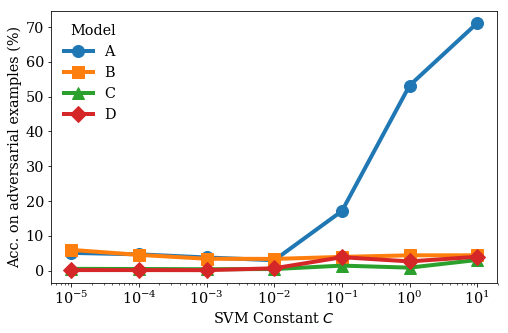

In [57]:
marker = ['o', 's', '^', 'D', 'v', 'X', 'd', '+']
labels = ['A', 'B', 'C', 'D']
C = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.semilogx(C, adv_acc[i*7:(i+1)*7, 3] * 100, label=labels[i], marker=marker[i])
#plt.axhline(y=10.23, linestyle='--', c='purple', linewidth=3, label='Original')
plt.legend()
plt.xlabel(r'SVM Constant $C$')
plt.ylabel('Acc. on adversarial examples (%)')
legend = plt.legend(title='Model', fontsize='x-large', loc='upper left')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/combine_adv.pdf', bbox_inches='tight')
plt.show()

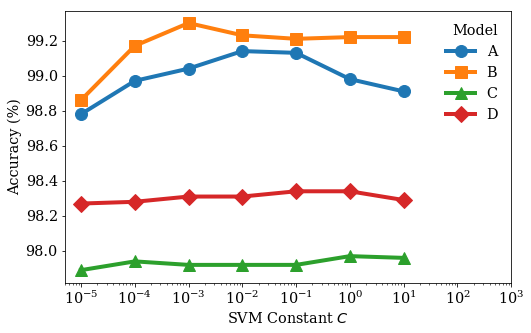

In [63]:
marker = ['o', 's', '^', 'D', 'v', 'X', 'd', '+']
labels = ['A', 'B', 'C', 'D']
C = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.semilogx(C, acc[i*7:(i+1)*7, 1] * 100, label=labels[i], marker=marker[i])
#plt.axhline(y=10.23, linestyle='--', c='purple', linewidth=3, label='Original')
plt.xlim(xmax=1000)
plt.legend()
plt.xlabel(r'SVM Constant $C$')
plt.ylabel('Accuracy (%)')
legend = plt.legend(title='Model', fontsize='x-large', loc='upper right')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/combine_acc.pdf', bbox_inches='tight')
plt.show()

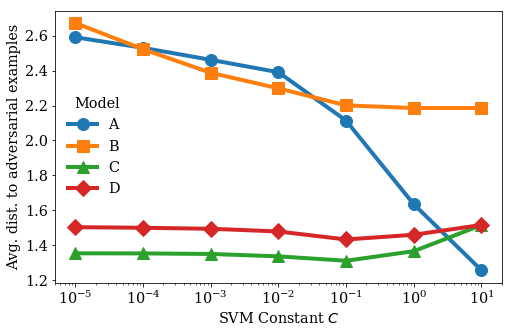

In [76]:
marker = ['o', 's', '^', 'D', 'v', 'X', 'd', '+']
labels = ['A', 'B', 'C', 'D']
C = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.semilogx(C, norm[i*7:(i+1)*7, 3], label=labels[i], marker=marker[i])
#plt.axhline(y=10.23, linestyle='--', c='purple', linewidth=3, label='Original')
plt.legend()
plt.xlabel(r'SVM Constant $C$')
plt.ylabel('Avg. dist. to adversarial examples')
legend = plt.legend(title='Model', fontsize='x-large')
plt.setp(legend.get_title(), fontsize='x-large')
legend._legend_box.align = "right"
plt.savefig('./fig/combine_norm.pdf', bbox_inches='tight')
plt.show()